**Establishing Sequences of Organizational Patterns with bigrams**

Index of the highest probability in a vector of probabilities as output from the Softmax regression model points to first pattern which should be used in pattern sequence. Second-highest probability points to second pattern in this sequence. Third probability points to third pattern in pattern sequence...

This work is a natural continuation of previous research conducted by Waseeb et al. in 'Extracting Relations Between Organizational Patterns Using Association Mining' which you can find here: http://www2.fiit.stuba.sk/~vranic/pub/ExtractingRelations.pdf. 

Dataset we're working on is quite similar to the one published on page 4 in Table 1 entitled as "A matrix sample values for n-gram existence against org. patterns". Difference is that we use TF-IDF frequencies instead of the binary-encoded attributes. This design allows us to flow information between artificial neurons in our artificial neural network model.

Sample dataset with frequencies of 11 trigrams extracted from textual descriptions of the organizational patterns from http://www.orgpatterns.com/ had been provided in Excel sheet as training, validation and test set. Validation and test sets consist of another for model previously unseen organizational patterns.

<u>Model output example</u>:

Training dataset consists of frequencies of the trigrams for 18 organizational patterns. Output from this Artificial Neural Network is a vector for a pattern with frequencies from a validation and test dataset with as many components as there are patterns in this dataset:

for $pattern_{i}$ = (x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18),

where $x_{i}$ is output from a softmax regression and it's a likelihood of this pattern given observed frequencies of its trigrams. Highest probability from this vector is a classification of the set of the trigram inverse frequencies for a given organizational pattern.

**Main Idea of our Approach**

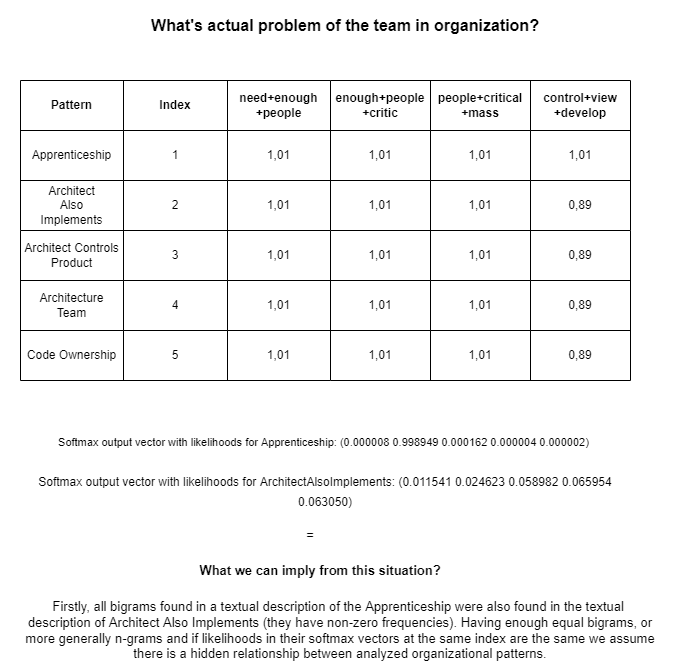

Validation dataset should be used to optimalize hyperparameters (parameters which are not trained during computation of this ANN) and test dataset shall be used only once.

Please note that prediction is correct if it is consistent with an actual class. Accuracy of the model is one of the metrics used to evaluate this behavior.

Theory behind this can be found in a book Dive into Deep Learning: https://d2l.ai/chapter_linear-networks/softmax-regression.html

In [1]:
import tensorflow as tf
# keras is facade for tensorflow so we don't have to deal with low-level API
from tensorflow import keras 
from tensorflow.keras.models import Sequential # composite pattern for building neural network
from tensorflow.keras.layers import Dense # input, hidden and output layer
from tensorflow.keras.losses import categorical_crossentropy # loss function
from keras.utils.np_utils import to_categorical # hot-encoding for softmax regression
from tensorflow.keras.optimizers import Adam # optimalizer for neural network

# library for data preprocessing and model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import numpy as np # to handle data compactly
import pandas as pd
import matplotlib.pyplot as plt # plotting library

import os

# get the current working directory
current_working_directory = os.getcwd()

tf.keras.backend.clear_session()

train_df = pd.read_excel(current_working_directory + '\\trigram-pattern-frequencies\\trigram-pattern-frequencies-train.xlsx', engine='openpyxl')
val_df = pd.read_excel(current_working_directory + '\\trigram-pattern-frequencies\\trigram-pattern-frequencies-val.xlsx', engine='openpyxl')
test_df = pd.read_excel(current_working_directory + '\\trigram-pattern-frequencies\\trigram-pattern-frequencies-test.xlsx', engine='openpyxl')

**Normalization of organizational patterns trigram frequencies**

Why? Because some of the trigrams (independent variables, attributes X) have higher frequencies than the others. This means they are used more in organizational pattern descriptions than those which are used less. We will normalize these attributes so they contribute equally to the model training process. Normalization is often a must-be to in order to get acceptable results from a machine learning or deep learning models.

Because some of the trigrams are used more often than the others they differ in a (statistical) variance. This means they must be normalized because of this fact too. It's not very good to increase learning rate (as one of the hyperparameters of this neural network) when attributes are not normalized before. This could lead to divergency, when we wouldn't be able to find best parameters in our training process.

Good news is we don't have to weigth our labels (indexes representing organizational patterns) since each class (organizational pattern) is represented only once in our working dataset.

In [2]:
number_of_patterns = 19

train_scaler = StandardScaler()
train_without_target = train_df.drop(['PatternIndex'], axis=1)
train_without_pattern_name = train_without_target.drop(['OrganizationalPattern'], axis=1)
train_features = train_scaler.fit(train_without_pattern_name.values)

X_train = pd.DataFrame(train_scaler.transform(train_df.iloc[:, 1:-1].values))
y_train = to_categorical(train_df.iloc[:,-1].values, number_of_patterns) # hot-encoding label (pattern index) for softmax regression

val_scaler = StandardScaler()
val_without_target = val_df.drop(['PatternIndex'], axis=1)
val_without_pattern_name = val_without_target.drop(['OrganizationalPattern'], axis=1)
val_features = val_scaler.fit(val_without_pattern_name.values)

X_val = pd.DataFrame(val_scaler.transform(val_df.iloc[:, 1:-1].values))
y_val = to_categorical(val_df.iloc[:,-1].values, number_of_patterns)

test_scaler = StandardScaler()
test_without_target = test_df.drop(['PatternIndex'], axis=1)
test_without_pattern_name = test_without_target.drop(['OrganizationalPattern'], axis=1)
test_features = test_scaler.fit(test_without_pattern_name.values)

X_test = pd.DataFrame(test_scaler.transform(test_df.iloc[:, 1:-1].values))
y_test = to_categorical(test_df.iloc[:,-1].values, number_of_patterns)  

**SoftMax Classification of organizational patterns based on their trigram TF-IDF frequencies**

Activation functions are those components in neural network which are responsible to generate output from a network. Combination of linear functions (layers of the ANN without these functions perform affine transformations only) is still a linear function. That's why we need non-linear activation function. Non-linear activation functions help us to take advantage of the GPU processing capabilities.

We must use non-linear activation functions because if we try to visualize frequencies of the trigrams in 2D space we would not be able to separate these data with linear functions or its lines.

ReLU is one of the standard activation functions used in the neural networks. Softmax is activation function too. Number passed as argument to the constructor of the layer of our Artificial Neural Network is number of perceptrons on this layer. Dropout layer is used as regularization technique to eliminate overfitting of the model on training dataset.

First dense layer is our input layer, or layer to consume our dataset. It has 11 neurons, because we have 11 trigrams in our training dataset. Last layer is output layer of this neural network. All layers between are hidden layers of this neural network. All layers are fully connected layers of this Multi-layer perceptron.

What we're doing here? Well, we go through these steps for 100 epochs:

 1. we pass here our dataset
 2. we declare Articial Neural Network as Multilayer Perceptron. See https://d2l.ai/chapter_multilayer-perceptrons/index.html
 3. we declare optimizer which we want to use. It's Adam, best in class: https://arxiv.org/pdf/1412.6980.pdf
 4. we work with-minibatches. We optimize model parameters passing each 4 rows in our dataset. Batches are passed randomly.
 5. we perform forward pass through this neural network. That means we actually generate predictions.
 6. we compute loss and cost from our predictions
 7. we propagate back this loss through all the layers of ANN. In fact, we propagate gradients.
 8. we upgrade parameters with our gradients and use upgraded parameters for another forward pass of this MLP.

At the end we use one of the standards visualization techniques for model evaluation.

In [3]:
NUMBER_OF_TF_IDF_FEATURES = 11

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(11),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(19, activation="softmax")
])

model.compile(optimizer='adam',
                loss=categorical_crossentropy,
                metrics=["accuracy"])

BATCH_SIZE = 4
EPOCHS = 100
SHUFFLE = True

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_val, y_val), shuffle=SHUFFLE)

Epoch 1/100
5/5 [==============================] - 1s 46ms/step - loss: 2.9854 - accuracy: 0.1111 - val_loss: 2.9643 - val_accuracy: 0.0556
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9550 - accuracy: 0.0000e+00 - val_loss: 2.9604 - val_accuracy: 0.0556
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9859 - accuracy: 0.0556 - val_loss: 2.9566 - val_accuracy: 0.0556
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 2.9193 - accuracy: 0.0000e+00 - val_loss: 2.9523 - val_accuracy: 0.0556
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 2.9609 - accuracy: 0.0000e+00 - val_loss: 2.9484 - val_accuracy: 0.0556
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9410 - accuracy: 0.0556 - val_loss: 2.9442 - val_accuracy: 0.0556
Epoch 7/100
5/5 [==============================] - 0s 10ms/step - loss: 2.9561 - accuracy: 0.0556 - val_loss: 2.9395 - val_accuracy: 0.0556
Epoch 8/100
5

5/5 [==============================] - 0s 7ms/step - loss: 2.7611 - accuracy: 0.0556 - val_loss: 2.7350 - val_accuracy: 0.1111
Epoch 60/100
5/5 [==============================] - 0s 8ms/step - loss: 2.7720 - accuracy: 0.1111 - val_loss: 2.7336 - val_accuracy: 0.1111
Epoch 61/100
5/5 [==============================] - 0s 8ms/step - loss: 2.7307 - accuracy: 0.1111 - val_loss: 2.7326 - val_accuracy: 0.1111
Epoch 62/100
5/5 [==============================] - 0s 9ms/step - loss: 2.7518 - accuracy: 0.1111 - val_loss: 2.7312 - val_accuracy: 0.1111
Epoch 63/100
5/5 [==============================] - 0s 9ms/step - loss: 2.7368 - accuracy: 0.0556 - val_loss: 2.7299 - val_accuracy: 0.1111
Epoch 64/100
5/5 [==============================] - 0s 12ms/step - loss: 2.7301 - accuracy: 0.1111 - val_loss: 2.7288 - val_accuracy: 0.1111
Epoch 65/100
5/5 [==============================] - 0s 13ms/step - loss: 2.7188 - accuracy: 0.1111 - val_loss: 2.7278 - val_accuracy: 0.1111
Epoch 66/100
5/5 [=============

We still have a low accuracy (bias) mostly because we still deal with a very small dataset. Loss here is a value of the cost function (losses for all predictions). Val_loss is a model variance.

Because loss is lower than a validation loss (though still not significantly) our probability prediction model is said to be <u>overfitting</u>. This is why we have employed one of the regularization techniques for neural networks - we've added Dropout layer. Documentation for this approach can be found in the work of Srivastava et al. Dropout - A Simple Way to Prevent Neural Networks from Overfitting which you can find here https://jmlr.org/papers/v15/srivastava14a.html

**ANN Training Visualization**

Accuracy increased with epochs which is intended behavior.

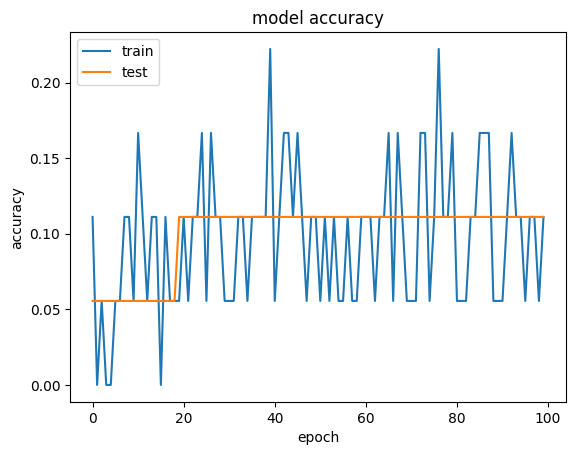

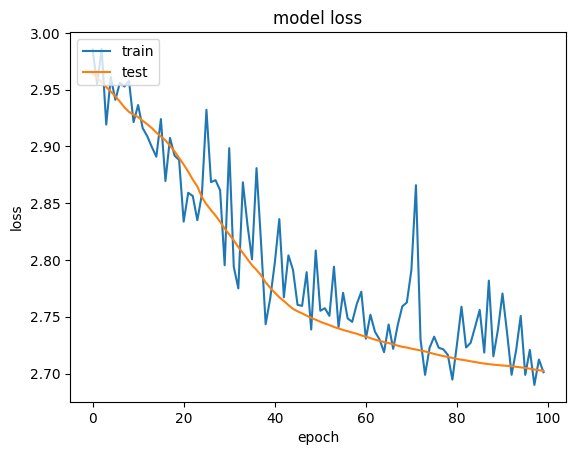

In [4]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Architecture of this Artificial Neural Network**

This neural network consists of one input layer (without parameters), 3 hidden fully-connected layers and one output layer.

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                360       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 19)                589       
                                                                 
Total params: 2,809
Trainable params: 2,809
Non-trainable params: 0
_________________________________________________________________


**Evaluation of the Multilayer perceptron**

Now we have to evaluate our classification model. Non-overfitting softmax regression model for us is a model with roughly same accuracy on a training, validation and test dataset. Visualization through the confusion matrix will help us evaluate model performance on these three types of the data sets.

So now we're going to check our classification accuracy on the validation and test dataset. For evaluation we use a confusion matrix. Confusion matrix consists from the ones and zeros because in our case each organizational pattern in our dataset is represented only once. This could be changed by processing other pattern descriptions from other types of sources but always for the same pattern set. Ones are visible at those places where model classified organizational pattern based on its inverse n-gram frequencies.

**Model Evaluation on validation dataset**

Although model is a deep neural network and should be strong enough, it's incapable to classify most of the organizational patterns correctly according to triplets of terms which have been used to document these organizational patterns. Model has successfully identified Apprenticeship and Organization Follows Market organizational patterns.

Obvious incapability of the model to classify well (ones in confusion matrix cannot be said to be diversified) is a consequence of the similar TF-IDF frequencies in a dataset.

**Expected pattern sequence from the patterns in validation set**

Although model is a deep neural network and should be strong enough, it's incapable to classify most of the organizational patterns correctly according to triplets of terms which have been used to document these organizational patterns. Model has successfully identified Apprenticeship and Feature Assignment organizational patterns.

Apprenticeship (p=0.998081) -> Domain Expertise In Roles (p=0.063485) -> Standup Meeting (p=0.061498)

This pattern sequence documents usual setting in development teams created by Size The Organization. Novice developers work with older senior colleagues who are expert in their roles and help them to develop new features or maintain existing products. Development team usually consists of the sub-teams responsible for their particular products and these sub-teams must meet too to discuss what's going on and work plan for the future.

**What these patterns solve**

Apprenticeship is about assigning inexperienced developer to the more experienced one to distribute knowledge to next generation.

Domain Expertise In Roles is concetrating developers around domain experts (or subject matter experts) who lead development and maintenance of the products.

Standup Meeting is about meeting of the development team at frequent and stable intervals, discussing problems, topics and next work plan.

1/1 [==============================] - 0s 74ms/step
probabilities in softmax vectors
each value in this vector is a probability that a given row / textual description is a pattern from dataset
[[0.000000 0.998081 0.000007 0.000373 0.000053 0.000039 0.000100 0.000064
  0.000571 0.000091 0.000223 0.000119 0.000021 0.000013 0.000050 0.000081
  0.000075 0.000009 0.000030]
 [0.004880 0.019761 0.056480 0.052796 0.057720 0.061018 0.059529 0.061031
  0.055630 0.051398 0.052814 0.063485 0.054160 0.061498 0.047538 0.059672
  0.059602 0.063797 0.057189]
 [0.004880 0.019761 0.056480 0.052796 0.057720 0.061018 0.059529 0.061031
  0.055630 0.051398 0.052814 0.063485 0.054160 0.061498 0.047538 0.059672
  0.059602 0.063797 0.057189]
 [0.004880 0.019761 0.056480 0.052796 0.057720 0.061018 0.059529 0.061031
  0.055630 0.051398 0.052814 0.063485 0.054160 0.061498 0.047538 0.059672
  0.059602 0.063797 0.057189]
 [0.004880 0.019761 0.056480 0.052796 0.057720 0.061018 0.059529 0.061031
  0.055630 0.051398 0

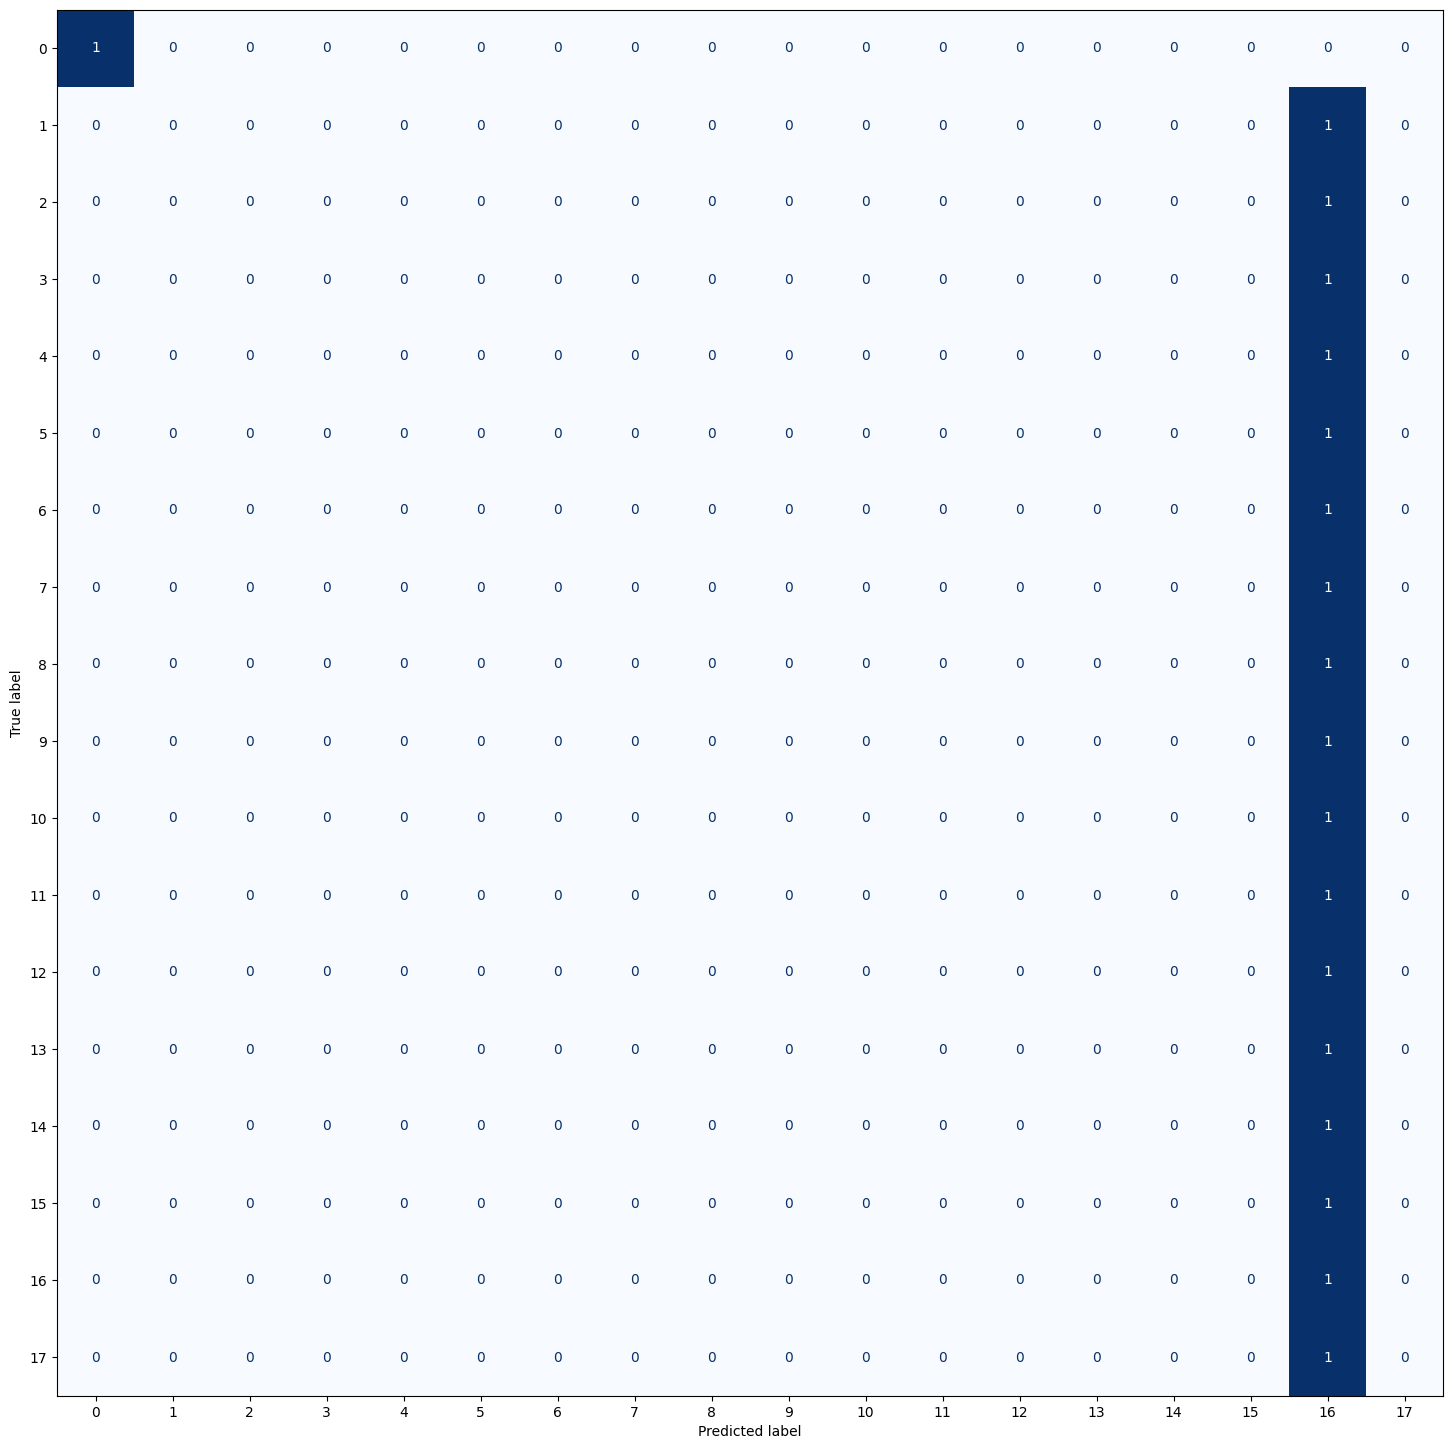

In [5]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(18))
    cm.plot(values_format='d', cmap='Blues', ax=ax, colorbar=False)
    
# we don't want to see small probabilities in exponential form
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

softmax_vectors = model.predict(X_val)
print('probabilities in softmax vectors')
print('each value in this vector is a probability that a given row / textual description is a pattern from dataset')
print(softmax_vectors)
indexes_of_predicted_patterns = np.argmax(softmax_vectors, axis=1)
pattern_names_from_one_hot_encodings = np.argmax(y_val, axis=1)
plot_confusion_matrix(pattern_names_from_one_hot_encodings, indexes_of_predicted_patterns)

**Model Evaluation on test dataset**

Model doesn't work well on a test dataset and it was able to correctly identify only Size The Organization organizational pattern.

**Expected pattern sequence from the patterns in test set**

Architecture Team (p=0.057077) -> Few Roles (p=0.055865) -> Generics and Specifics (p=0.055788)

This pattern sequence documents usual setting of the working on the development project. First experienced senior developers choose the technology to work with, then initial software product architecture is designed by them. Some members of this initial group of experienced staff are chosen to develop the generic framework to be used, incorporated and customized in the application by novices or less experienced staff.

**What these patterns solve**

Architecture Team is about creating small team to define initial architecture.

Few Roles is about having only small number of the producer roles in the team.

Generics and Specifics is about letting experienced senior developers create the framework and let novices use this framework and include it into specific applications.

1/1 [==============================] - 0s 15ms/step
probabilities in softmax vectors
each value in this vector is a probability that a given row / textual description is a pattern from dataset
[[0.018787 0.058038 0.053589 0.056778 0.052771 0.053494 0.052877 0.055454
  0.054131 0.055207 0.055865 0.055788 0.052476 0.052836 0.055596 0.053148
  0.057077 0.052811 0.053277]
 [0.018787 0.058038 0.053589 0.056778 0.052771 0.053494 0.052877 0.055454
  0.054131 0.055207 0.055865 0.055788 0.052476 0.052836 0.055596 0.053148
  0.057077 0.052811 0.053277]
 [0.018787 0.058038 0.053589 0.056778 0.052771 0.053494 0.052877 0.055454
  0.054131 0.055207 0.055865 0.055788 0.052476 0.052836 0.055596 0.053148
  0.057077 0.052811 0.053277]
 [0.018787 0.058038 0.053589 0.056778 0.052771 0.053494 0.052877 0.055454
  0.054131 0.055207 0.055865 0.055788 0.052476 0.052836 0.055596 0.053148
  0.057077 0.052811 0.053277]
 [0.018787 0.058038 0.053589 0.056778 0.052771 0.053494 0.052877 0.055454
  0.054131 0.055207 0

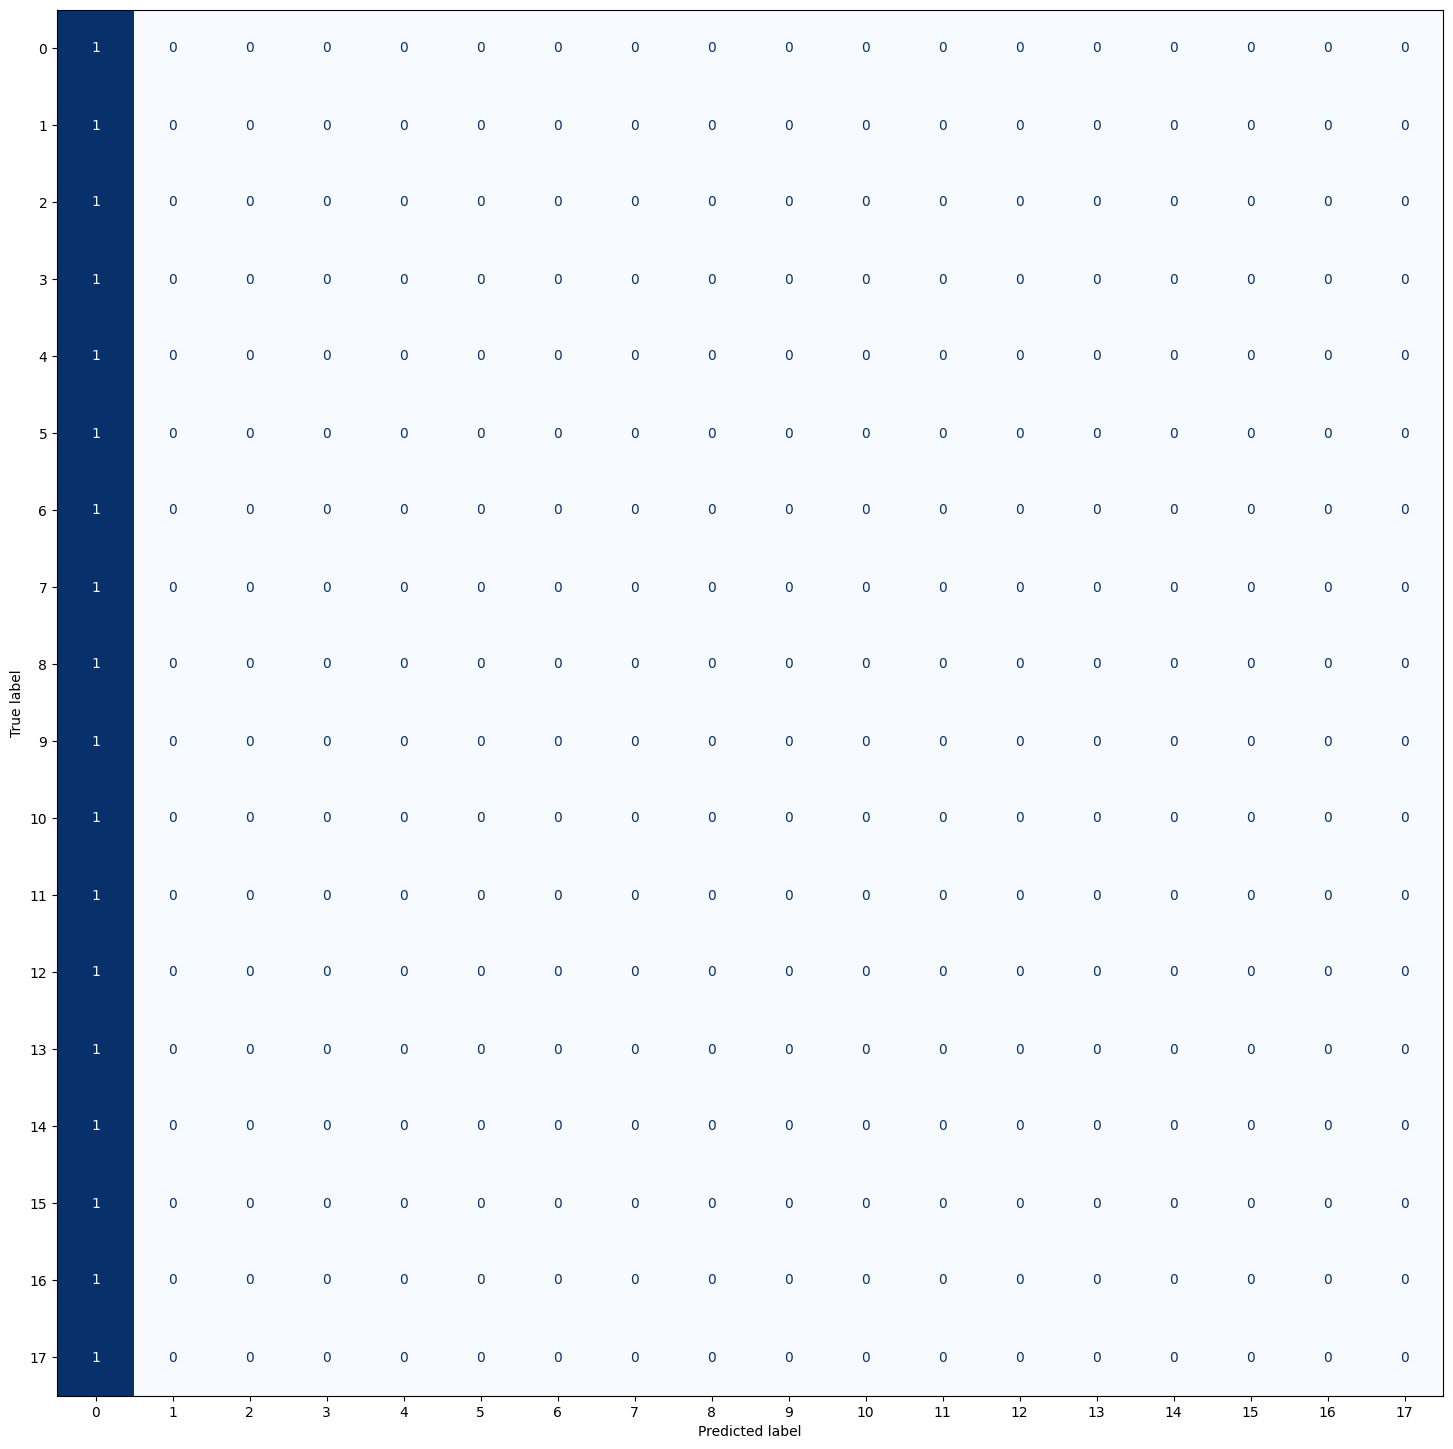

In [6]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(18))
    cm.plot(values_format='d', cmap='Blues', ax=ax, colorbar=False)
    
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

softmax_vectors = model.predict(X_test)
print('probabilities in softmax vectors')
print('each value in this vector is a probability that a given row / textual description is a pattern from dataset')
print(softmax_vectors)
indexes_of_predicted_patterns = np.argmax(softmax_vectors, axis=1)
pattern_names_from_one_hot_encodings = np.argmax(y_test, axis=1)
plot_confusion_matrix(pattern_names_from_one_hot_encodings, indexes_of_predicted_patterns)

**Conclusion**

Two expected pattern sequences have been found:

1. Apprenticeship (p=0.998081) -> Domain Expertise In Roles (p=0.063485) -> Standup Meeting (p=0.061498). This pattern sequence documents usual setting in development teams created by Size The Organization. Novice developers work with older senior colleagues who are expert in their roles and help them to develop new features or maintain existing products. Development team usually consists of the sub-teams responsible for their particular products and these sub-teams must meet too to discuss what's going on and work plan for the future.
2. Architecture Team (p=0.057077) -> Few Roles (p=0.055865) -> Generics and Specifics (p=0.055788). This pattern sequence documents usual setting of the working on the development project. First experienced senior developers choose the technology to work with, then initial software product architecture is designed by them. Some members of this initial group of experienced staff are chosen to develop the generic framework to be used, incorporated and customized in the application by novices or less experienced staff.

This model should be provided extensive dataset, with more than triples of the terms (trigrams), more attributes and more organizational patterns from numerous sources. TF-IDF frequencies of terms used to describe organizational patterns should not be similar (model is sensitive if they are similar and unable to generate good predictions).